In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt update
!apt install -y cmake
!pip install pymorphy2

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.co

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
from collections import Counter
import operator
import numpy as np
from math import log2, sqrt
from os import listdir
from os.path import isfile, join
import nltk
from nltk.collocations import *
import pandas as pd
from tqdm import tqdm

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/магистратура/BERT/Выборки/sample_for_bert_new_full_info(16.04.2022).csv", sep=",")

# 1. Настройка

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.5 MB/s 
     |████████████████████████████████| 895 kB 37.6 MB/s 
     |████████████████████████████████| 596 kB 35.6 MB/s 
     |████████████████████████████████| 6.6 MB 31.9 MB/s 
     |████████████████████████████████| 77 kB 3.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# 2. Загрузка набора данных CoLA

## 2.1. Скачать и извлечь

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=e5659596d3854aa9a60914be5bfafae323b88c95461cba9ee3e8e3449ec90089
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


## 2.2. Разобрать

In [ ]:
df.sample(10)

,Unnamed: 0,norm_form,real_view,f_a,f_b,f_ab,f_a_contrasting,f_b_contrasting,f_ab_contrasting,part_of_speech_a,...,measure_comb_5,measure_comb_weardness,rang_mi,rang_mi3,rang_t_score,rang_minimum_sensitivity,rang_dice,rang_weirdness,measure_comb_weirdness,class
2332,644491,"('определяться', 'выражение')",определяется выражением,289,122,2,13,1153,0,INFN,...,4.345261e+09,1.040760e+07,10000,10000,10000,10000,10000,10000,1.728665e+06,1
2758,845295,"('истинный', 'причина')",истинной причиной,38,520,1,362,968,9,ADJF,...,6.497172e+09,1.040760e+07,10000,10000,10000,10000,10000,10000,1.728665e+06,1
851,50819,"('значительный', 'роль')",значительная роль,455,824,15,201,276,1,ADJF,...,1.984742e+09,1.040760e+07,10000,10000,10000,10000,10000,10000,1.202767e+06,1
463,16857,"('тот', 'факт')",того факта,3005,212,32,22140,187,45,ADJF,...,1.527502e+09,1.040760e+07,10000,10000,10000,10000,10000,10000,1.369487e+06,1
398,13262,"('другой', 'слово')",другими словами,2772,311,35,8628,4524,28,ADJF,...,1.704572e+09,1.040760e+07,10000,10000,10000,10000,10000,10000,1.124401e+06,1
1721,294109,"('иметься', 'бугорок')",имеющих бугорки,501,45,1,270,4,0,INFN,...,6.740495e+09,1.040760e+07,10000,10000,10000,10000,10000,10000,1.728665e+06,0
544,22305,"('вероятность', 'ошибка')",вероятность ошибки,134,73,2,64,354,1,NOUN,...,2.973957e+09,1.040760e+07,10000,10000,10000,10000,10000,10000,1.357194e+06,1
1864,419075,"('исчерпываться', 'работа')",исчерпывается работа,9,971,1,2,1310,0,INFN,...,5.247666e+09,1.040760e+07,10000,10000,10000,10000,10000,10000,1.728665e+06,1
923,57743,"('разный', 'направление')",разными направления,1305,833,19,705,517,11,ADJF,...,2.909503e+09,1.040760e+07,10000,10000,10000,10000,10000,10000,1.376402e+06,0
1720,293682,"('который', 'необходимый')",которым необходима,6404,389,8,20852,289,0,ADJF,...,7.246348e+09,1.040760e+07,10000,10000,10000,10000,10000,10000,1.728665e+06,1


In [ ]:
df.loc[df["class"] == 0].sample(5)[['real_view', 'class']]

,real_view,class
1177,высокие нервные,0
975,особенностями организаций,0
2404,подручный предмет,0
2473,участие наиболее,0
2149,одно причинноследственных,0


In [ ]:
# Get the lists of sentences and their labels.
sentences = df.real_view.values
labels = df["class"].values

# 3. Токенизация и форматирование ввода


## 3.1. Токенизатор BERT

In [ ]:
# "bert-base-multilingual-cased" 
# "DeepPavlov/rubert-base-cased"
# "DeepPavlov/distilrubert-tiny-cased-conversational-v1"
# "DeepPavlov/rubert-base-cased-sentence"
# "DeepPavlov/distilrubert-tiny-cased-conversational"


In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.3 MB/s 


In [ ]:
from transformers import BertTokenizer, RobertaTokenizer
model_name = "DeepPavlov/bert-base-multilingual-cased-sentence" 
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  московский государственный
Tokenized:  ['м', '##ос', '##ков', '##ски', '##и', 'государств', '##ен', '##ны', '##и']
Token IDs:  [553, 17969, 13036, 11434, 10191, 82552, 10928, 11307, 10191]


In [ ]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  13


In [ ]:
max_len = 16

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  московский государственный
Token IDs: tensor([  101,   553, 17969, 13036, 11434, 10191, 82552, 10928, 11307, 10191,
          102,     0,     0,     0,     0,     0])


In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,997 training samples
  856 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Обучите нашу модель классификации

## 4.1. BertForSequenceClassification

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    
    
    # For example:
    # "bert-base-multilingual-cased" 
    # "DeepPavlov/rubert-base-cased"
    #  Другие варианты моделей - https://huggingface.co/DeepPavlov
    # "dslim/bert-base-NER", "dslim/bert-large-NER" - именованные сущности выявление
    # именованные сущности на русском "explosion/ru_udv25_russiangsd_trf" надо доработать (сразу не заработает)

    
    model_name, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/678M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/bert-base-multilingual-cased-sentence and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

## 4.2. Оптимизатор и планировщик скорости обучения

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Тренировочный цикл

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     63.    Elapsed: 0:00:15.

  Average training loss: 0.56
  Training epcoh took: 0:00:23

Running Validation...
  Accuracy: 0.72
  Validation Loss: 0.55
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     63.    Elapsed: 0:00:15.

  Average training loss: 0.39
  Training epcoh took: 0:00:23

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.48
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     63.    Elapsed: 0:00:15.

  Average training loss: 0.29
  Training epcoh took: 0:00:23

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.50
  Validation took: 0:00:02

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     63.    Elapsed: 0:00:15.

  Average training loss: 0.23
  Training epcoh took: 0:00:23

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.53
  Validation took: 0:00:02

Training complete!
Total tr

Подведем итоги тренировочного процесса.

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.56,0.55,0.72,0:00:23,0:00:02
2,0.39,0.48,0.80,0:00:23,0:00:02
3,0.29,0.50,0.80,0:00:23,0:00:02
4,0.23,0.53,0.80,0:00:23,0:00:02


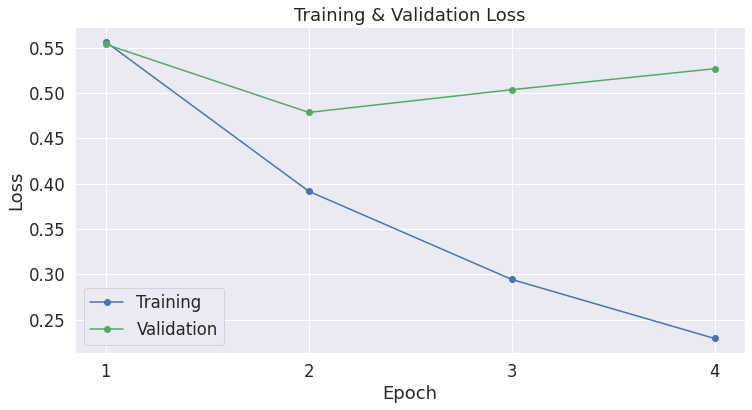

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# 5. Производительность на тестовом наборе

### 5.1. Подготовка данных

In [ ]:
import pandas as pd

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.real_view.values
labels = df["class"].values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32 

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 2,853



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## 5.2. Оценить на тестовом наборе

In [ ]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, balanced_accuracy_score, precision_score, recall_score
matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')
f_measure = []
pres = []
rec = []
acc = []
# For each input batch...
true_label = []
pred_label = []
for i in range(len(true_labels)):
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  true_label+=list(true_labels[i])
  pred_label+=list(pred_labels_i)
  # print(true_labels[i])
print("f1_score: ", f1_score(true_label, pred_label) , "  ", "accuracy: ", accuracy_score(true_label, pred_label) , "  ", "precision: ", precision_score(true_label, pred_label) , "  ", "recall: ", recall_score(true_label, pred_label) )

# Calculate and store the coef for this batch.  
matthews = matthews_corrcoef(true_label, pred_label)                
matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...
f1_score:  0.8072976054732042    accuracy:  0.802570093457944    precision:  0.7937219730941704    recall:  0.8213457076566125


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,853 test sentences...
    DONE.


In [ ]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, balanced_accuracy_score, precision_score, recall_score
matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')
f_measure = []
pres = []
rec = []
acc = []
# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  # print(true_labels[i])
  f_measure.append(f1_score(true_labels[i], pred_labels_i))
  pres.append(precision_score(true_labels[i], pred_labels_i))
  rec.append(recall_score(true_labels[i], pred_labels_i))
  acc.append(accuracy_score(true_labels[i], pred_labels_i))
  print("f1_score: ", f1_score(true_labels[i], pred_labels_i), "  ", "accuracy: ", accuracy_score(true_labels[i], pred_labels_i), "  ", "precision: ", precision_score(true_labels[i], pred_labels_i), "  ", "recall: ", recall_score(true_labels[i], pred_labels_i))
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...
f1_score:  0.8695652173913043    accuracy:  0.90625    precision:  0.9090909090909091    recall:  0.8333333333333334
f1_score:  0.9655172413793104    accuracy:  0.96875    precision:  1.0    recall:  0.9333333333333333
f1_score:  0.8461538461538461    accuracy:  0.875    precision:  0.9166666666666666    recall:  0.7857142857142857
f1_score:  0.9090909090909091    accuracy:  0.9375    precision:  1.0    recall:  0.8333333333333334
f1_score:  0.6666666666666665    accuracy:  0.8125    precision:  0.5454545454545454    recall:  0.8571428571428571
f1_score:  0.7999999999999999    accuracy:  0.90625    precision:  0.75    recall:  0.8571428571428571
f1_score:  0.8    accuracy:  0.9375    precision:  0.6666666666666666    recall:  1.0
f1_score:  0.9    accuracy:  0.9375    precision:  0.9    recall:  0.9
f1_score:  0.9473684210526316    accuracy:  0.96875    precision:  0.9    recall:  1.0
f1_score:  0.8571428571428571    accuracy:  0.875  

In [ ]:
res_f = sum([m for m in f_measure])/len(f_measure)
res_a = sum([m for m in acc])/len(acc)
res_p = sum([m for m in rec])/len(rec)
res_r = sum([m for m in pres])/len(pres)
print(f"middle values of F-measure: {res_f}, accuracy: {res_a}, precission: {res_p}, recall: {res_r}")

middle values of F-measure: 0.8953854411950914, accuracy: 0.8988194444444444, precission: 0.9194082180812561, recall: 0.8817584711739934


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df["class"].sum(), len(df["class"]), (df["class"].sum() / len(df["class"]) * 100.0)))

Positive samples: 1430 of 2853 (50.12%)


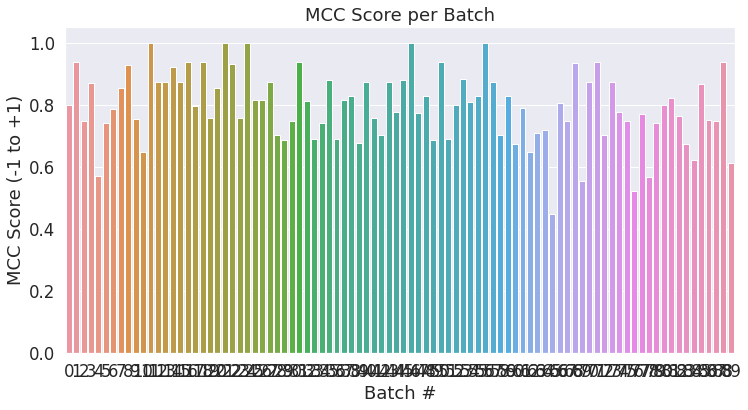

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.800


#ПРИМЕНЕНИЕ КЛАССИФИКАТОРА

In [ ]:
data2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/магистратура/DATABASE/database_ychebiki(22.03.22).csv', sep=',')

In [ ]:
data2.head()

,Unnamed: 0,Unnamed: 0.1,norm_form,real_view,f_a,f_b,f_ab,f_a_contrasting,f_b_contrasting,f_ab_contrasting,...,measure_comb_3,measure_comb_5,measure_comb_weardness,rang_mi,rang_mi3,rang_t_score,rang_minimum_sensitivity,rang_dice,rang_weirdness,measure_comb_weirdness
0,0,0,"('клетка', 'как')",клеток как,2848,5237,17,208,31805,0,...,1.73e+06,1.27e+10,1.04e+07,10000,10000,10000,10000,10000,10000,1.73e+06
1,1,1,"('как', 'рхитектурный')",как РХИТЕКТУРНОЕ,5237,1,1,31805,0,0,...,1.73e+06,4.68e+09,1.04e+07,10000,10000,10000,10000,10000,10000,1.73e+06
2,2,2,"('рхитектурный', 'чудо')",РХИТЕКТУРНОЕ чудес,1,23,1,0,244,0,...,1.02e+06,2.69e+09,1.04e+07,10000,10000,10000,10000,10000,10000,1.73e+06
3,3,3,"('ю', 'м')",Ю М,92,1101,1,16,567,0,...,1.73e+06,1.05e+10,1.04e+07,10000,10000,10000,10000,10000,10000,1.73e+06
4,4,4,"('васильев', 'московский')",Васильева Московский,16,14,2,2,228,0,...,8.24e+05,1.64e+09,1.04e+07,10000,10000,10000,10000,10000,10000,1.73e+06


In [ ]:
sentences = set(list(data2.real_view))
##sentences = sentences[:int(len(sentences)/3)]
# X = data2.norm_form
# colloc = set()
# i=0
# for tup in list(set(X)):
#   r = tup.replace("(", "")
#   r = r.replace(")", "")
#   r = r.replace("'", "")
#   r = r.replace(" ", "")
#   a = r.split(",")
#   if len(a[0]) > 2 and len(a[1]) > 2:
#     colloc.add(a[0]+' '+a[1])
#     i+=1
# sentences = list(colloc)

In [ ]:
del(data2)

In [ ]:
len(sentences)

451254

In [ ]:
import pandas as pd



# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)


# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=1)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 

for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  
  # Store predictions and true labels
  predictions.append(logits)

print('    DONE.')

Predicting labels for 451,254 test sentences...
    DONE.


In [ ]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, balanced_accuracy_score, precision_score, recall_score
matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Predictions values')
f_measure = []
pres = []
rec = []
acc = []
# For each input batch...
pred_label = []
for i in range(len(predictions)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  pred_label+=list(pred_labels_i)
  # print(true_labels[i])


Calculating Predictions values


In [ ]:
len(sentences)

451254

In [ ]:
len(pred_label)

451254

In [ ]:
res_colloc = []
sentences = list(sentences)

In [ ]:
for i in range(len(sentences)):
  if pred_label[i]:
    res_colloc.append(sentences[i])

In [ ]:
# res_df = pd.DataFrame({"colloc": sentences, "label": pred_label})
res_df = pd.DataFrame({"colloc": res_colloc})
len(res_colloc)

77266

In [ ]:
res_df.to_csv('/content/drive/My Drive/Colab Notebooks/магистратура/BERT/result_bert(29.04.22).csv')

In [ ]:
new_res = []
for i in res_colloc:
  a,b = i.split(" ")
  if len(a)>2 and len(b)>2:
    new_res.append(i)
print(len(new_res))

64470


In [ ]:
import pymorphy2

morph = pymorphy2.MorphAnalyzer()


res = []
norm_form = []
speach_stop =  ["PREP", "CONJ", "PRCL", "INTJ", "NPRO"] 

for i in new_res:
  a,b = i.split(" ")
  p = morph.parse(a)[0]
  if p.normal_form != "":
      p1 = p.normal_form
  p = morph.parse(b)[0]
  if p.normal_form != "":
      p2 = p.normal_form
  a = morph.parse(a)[0]
  a = a.tag.POS
  b = morph.parse(b)[0]
  b = b.tag.POS
  if i and a not in speach_stop and b not in speach_stop:
    res.append(i)
    norm_form.append(p1+" "+p2)

len(res)

53362

In [ ]:
res_df = pd.DataFrame({"colloc": res, "norm_form": norm_form})

In [ ]:
res_df.to_csv('/content/drive/My Drive/Colab Notebooks/магистратура/BERT/result_bert_after_filter(17.04.22).csv')

In [ ]:
res_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/магистратура/BERT/result_bert(17.04.22).csv', sep=',')

In [ ]:
data2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/магистратура/DATABASE/Tokens_from_all_collections(23.03.22).csv', sep=',')

In [ ]:
texts = []
text = []
sentences = []
for word in data2["Tokens"]:
  if word == "###":
    # texts.append(text)
    # text = []
    continue
  if word == ".":
    # text.append(sentences)
    texts.append(sentences)
    sentences = []
    continue
  sentences.append(word)

In [ ]:
data_set = []
num = 1

res_colloc = {i: i for i in list(res_df.colloc)}
with tqdm(total=len(texts), unit="sentences", mininterval=5) as progress_bar:
  for item in range(len(texts)):
    data_item = []
    for j in range(len(texts[item])-1):
      word1 = texts[item][j] 
      word2 = texts[item][j+1]
      if word1 + ' ' + word2 in res_colloc:
        data_item.append(word1 + '_' + word2)
      elif len(word1)>2:
        data_item.append(word1)
    progress_bar.update()
    if data_item!=[]:
      data_set.append(data_item)
    num+=1
  
print("\n", len(data_set))

100%|██████████| 1649892/1649892 [00:24<00:00, 66823.61sentences/s]


 943005


In [ ]:
res_sentences = []
for i in data_set:
  res_sentences.append(" ".join(i))

In [ ]:
res_sentences

['экспериментальные внланге физические задачи смекалкуфизика библиотечка физикоматематической школы ланге экспериментальные физические задачи смекалку издание третье исправленное дополненное москва наука главная редакция физикоматематической литературы удк физика библиотечка физикоматематической школы редактор серии смородинский ланге экспериментальные физические задачи сме калку учебное',
 'главная редакция зикоматематической',
 'библиотечка физикоматематической',
 'основная цель книги состоит воспитаний навыков нестан дартного',
 'знакомство историей физики показывает успех эксперимента часто определяется применением новых совершенно неожиданных специально случая разрабо танных методов',
 'книге приведено свыше ста задач которых предлагается придумать способ измерения величин пользуя самые_примитивные примитивные приборы казалось ходящие',
 'новом издании сделаны некоторые дополнения предыдущему',
 'учащихся общеобразовательных профессиональных школ интересующихся физикой учащихся фи

In [ ]:
data = pd.DataFrame({'arrays': res_sentences})
data.to_csv('/content/drive/My Drive/Colab Notebooks/магистратура/DATABASE/sentences_for_training_embeddings(18.04.22).csv')